In [11]:
cd /home/ec2-user/SageMaker/VIP-Dementia/audio_processing

/home/ec2-user/SageMaker/VIP-Dementia/audio_processing


In [12]:
import os
import pandas as pd
import librosa
import opensmile
from tqdm import tqdm

# Assuming the directory setup remains unchanged
HOME_DIRECTORY = os.path.expanduser("~/SageMaker/VIP-Dementia")
RAW_DATA_DIR = os.path.join(HOME_DIRECTORY, 'data/raw')
PROCESSED_DATA_DIR = os.path.join(HOME_DIRECTORY, 'data/processed')
FEATURES_DIR = os.path.join(PROCESSED_DATA_DIR, 'features')
LABELS_DIR = os.path.join(PROCESSED_DATA_DIR, 'labels')

# Label mapping for binary classification
label_dict = {'CN': 0, 'AD': 1}

def get_features(audio_path, sample_rate=16000):
    """
    Extract features for the entire audio file at a specified sampling rate.

    :param audio_path: Path to the audio file.
    :param sample_rate: Desired sampling rate (in Hz).
    :return: DataFrame containing extracted features.
    """
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPS,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    try:
        y, sr = librosa.load(audio_path, sr=sample_rate)
        features_df = smile.process_signal(y, sr)
        return features_df
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return pd.DataFrame()

def load_audio_data(sample_rate=16000):
    X, y = [], []
    partitions = ['ad', 'cn']
    total_ad_files = len([name for name in os.listdir(os.path.join(RAW_DATA_DIR, 'audio', 'ad')) if name.endswith('.wav')])
    total_cn_files = len([name for name in os.listdir(os.path.join(RAW_DATA_DIR, 'audio', 'cn')) if name.endswith('.wav')])
    total_files = total_ad_files + total_cn_files
    processed_count = 0

    for partition in partitions:
        audio_dir = os.path.join(RAW_DATA_DIR, 'audio', partition)
        audio_files = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith('.wav')]
        
        # Using tqdm to display progress
        with tqdm(total=len(audio_files), desc=f"Processing {partition.upper()} files") as pbar:
            for audio_path in audio_files:
                features_df = get_features(audio_path, sample_rate)
                if not features_df.empty:
                    X.append(features_df)
                    y.append(label_dict[partition.upper()])
                processed_count += 1
                pbar.update(1)

    print(f"\nFinished loading audio data. Successfully processed {processed_count} audio files out of {total_files} files.")
    return X, y

In [4]:
X, y = load_audio_data(sample_rate=22050) 

Processing AD files:   0%|          | 0/87 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/core/smile.py:251: UserWarning: Feature set 'FeatureSet.eGeMAPS' is deprecated, consider switching to 'FeatureSet.eGeMAPSv02'.
  warnings.warn(
Processing AD files:   1%|          | 1/87 [00:07<10:46,  7.52s/it]/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/core/smile.py:251: UserWarning: Feature set 'FeatureSet.eGeMAPS' is deprecated, consider switching to 'FeatureSet.eGeMAPSv02'.
  warnings.warn(
Processing AD files:   2%|▏         | 2/87 [00:11<07:54,  5.59s/it]/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/core/smile.py:251: UserWarning: Feature set 'FeatureSet.eGeMAPS' is deprecated, consider switching to 'FeatureSet.eGeMAPSv02'.
  warnings.warn(
Processing AD files:   3%|▎         | 3/87 [00:16<07:10,  5.12s/it]/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/


Finished loading audio data. Successfully processed 166 audio files out of 166 files.


In [10]:
import opensmile
import pandas as pd
import librosa

def get_features_windowed(audio_path, window_length_sec=0.100, step_size_sec=0.100, sample_rate=8000):
    """
    Extract features for audio within specified window lengths.

    :param audio_path: Path to the audio file.
    :param window_length_sec: Length of each window in seconds.
    :param step_size_sec: Step size between consecutive windows in seconds.
    :param sample_rate: Desired sampling rate (in Hz).
    :return: DataFrame containing extracted features for each window.
    """
    # Initialize openSMILE
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPS,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    # List to hold features from each window
    features_list = []

    # Calculate total duration of the audio file
    total_duration = librosa.get_duration(filename=audio_path, sr=sample_rate)

    # Initialize start position
    start = 0

    # Process each window until the end of the audio file
    while start < total_duration:
        end = start + window_length_sec
        if end > total_duration:
            end = total_duration

        # Extract features for the current window
        try:
            features_df = smile.process_file(
                file=audio_path,
                start=start,
                end=end
            )
            features_list.append(features_df)
        except Exception as e:
            print(f"Error processing file {audio_path} from {start}s to {end}s: {e}")

        # Move to the next window
        start += step_size_sec

    # Concatenate all features into a single DataFrame
    if features_list:
        full_df = pd.concat(features_list)
        # Fill NaNs with the mean of each column
        return full_df.fillna(full_df.mean())
    else:
        return pd.DataFrame()

In [11]:
# Example usage
features_df = get_features_windowed('/home/ec2-user/SageMaker/VIP-Dementia/data/raw/audio/ad/adrso024.wav')
print(features_df)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/core/smile.py:251: UserWarning: Feature set 'FeatureSet.eGeMAPS' is deprecated, consider switching to 'FeatureSet.eGeMAPSv02'.
  warnings.warn(
/tmp/ipykernel_25637/3750106551.py:25: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  total_duration = librosa.get_duration(filename=audio_path, sr=sample_rate)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/opensmile/core/smile.py:301: UserWarning: Segment too short, filling with NaN.
  warnings.warn(


                                                                                                     F0semitoneFrom27.5Hz_sma3nz_amean  \
file                                               start                  end                                                            
/home/ec2-user/SageMaker/VIP-Dementia/data/raw/... 0 days 00:00:00        0 days 00:00:00.100000                             21.041960   
                                                   0 days 00:00:00.100000 0 days 00:00:00.200000                             26.809732   
                                                   0 days 00:00:00.200000 0 days 00:00:00.300000                             20.067272   
                                                   0 days 00:00:00.300000 0 days 00:00:00.400000                             28.167391   
                                                   0 days 00:00:00.400000 0 days 00:00:00.500000                             13.460354   
...                               

/tmp/ipykernel_25637/3750106551.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat(features_list)


In [5]:
from sklearn.model_selection import train_test_split


features_df = pd.concat(X, ignore_index=True)
labels_series = pd.Series(y)
print(f'\nAudio samples represented: {len(X)}')  # Total number of audio files processed
print(f'Numerical features extracted per sample: {features_df.shape[1]}')
print(f'Unique labels in dataset: {labels_series.unique()}')

# Display the first few rows of the features DataFrame to check the data
features_df.head()

# Assuming 'features_df' and 'labels_series' are already defined and contain all your data
X = features_df
y = labels_series

# First, split into a training and a temp set (combining validation and test) with an 80/20 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then split the temp set equally into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Display sizes of the datasets
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_valid.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Audio samples represented: 166
Numerical features extracted per sample: 88
Unique labels in dataset: [1 0]
Training set size: 132
Validation set size: 17
Test set size: 17


In [ ]:
import os
import numpy as np

# Specify the directory where you want to save the files
HOME_DIRECTORY = os.path.expanduser("~/SageMaker/VIP-Dementia")
save_dir = SPLIT_DATA_DIR = '~/SageMaker/VIP-Dementia/data/processed/eGeMaps/44100'

# Function to save datasets
def save_dataset(filename, dataset):
    path = os.path.join(save_dir, filename)
    np.save(path, dataset)
    print(f"Saved {filename} to {save_dir}")

# Saving each dataset
save_dataset('X_train.npy', X_train)
save_dataset('X_valid.npy', X_valid)
save_dataset('X_test.npy', X_test)
save_dataset('y_train.npy', y_train)
save_dataset('y_valid.npy', y_valid)
save_dataset('y_test.npy', y_test)


In [13]:
import os
import numpy as np

HOME_DIRECTORY = os.path.expanduser("~/SageMaker/VIP-Dementia")
# saved_dir = "~/SageMaker/VIP-Dementia/data/processed/eGeMAPS/16000"
save_dir = os.path.join(HOME_DIRECTORY, 'data/processed/eGeMAPS/44100')
SPLIT_DATA_DIR = save_dir

# Function to load datasets
def load_dataset(filename):
    path = os.path.join(SPLIT_DATA_DIR, filename)
    if os.path.exists(path):
        return np.load(path, allow_pickle=True)
    else:
        print(f"File {filename} not found in {SPLIT_DATA_DIR}. Please check the directory and try again.")
        return None

# Loading each dataset
X_train = load_dataset('X_train.npy')
X_valid = load_dataset('X_valid.npy')
X_test = load_dataset('X_test.npy')
y_train = load_dataset('y_train.npy')
y_valid = load_dataset('y_valid.npy')
y_test = load_dataset('y_test.npy')

# Verifying the shapes of the loaded datasets (if they were successfully loaded)
if X_train is not None and y_train is not None:
    print(f"Loaded X_train: {X_train.shape}, y_train: {y_train.shape}")
if X_valid is not None and y_valid is not None:
    print(f"Loaded X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
if X_test is not None and y_test is not None:
    print(f"Loaded X_test: {X_test.shape}, y_test: {y_test.shape}")


Loaded X_train: (132, 88), y_train: (132,)
Loaded X_valid: (17, 88), y_valid: (17,)
Loaded X_test: (17, 88), y_test: (17,)


In [14]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier()
}

In [ ]:
model_outputs = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    probs = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)
    model_outputs[name] = (probs, preds)
print("All models trained and predictions stored.")

In [16]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import pandas as pd

def get_roc_curve(y_test, probs, model_name, color):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, linestyle='-', color=color, label=f'{model_name}', linewidth=0.7)
    plt.xlabel('False Positive Rate', fontsize=8)
    plt.ylabel('True Positive Rate', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(loc='lower right', fontsize=8)

def get_confusion_matrix(y_test, y_pred, class_names, model_name):
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  
    
    fig, ax = plt.subplots(figsize=(8, 6)) 
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def get_performance_metrics(y_test, model_outputs):
    metrics = {
        'Model': [],
        'Accuracy (%)': [],
        'Precision (%)': [],
        'Recall (%)': [],
        'F1-score (%)': []
    }

    for name, outputs in model_outputs.items():
        y_pred = outputs[1]
        metrics['Model'].append(name)
        metrics['Accuracy (%)'].append(100 * accuracy_score(y_test, y_pred))
        metrics['Precision (%)'].append(100 * precision_score(y_test, y_pred, average="macro"))
        metrics['Recall (%)'].append(100 * recall_score(y_test, y_pred, average="macro"))
        metrics['F1-score (%)'].append(100 * f1_score(y_test, y_pred, average="macro"))

    results_df = pd.DataFrame(metrics)
    return results_df

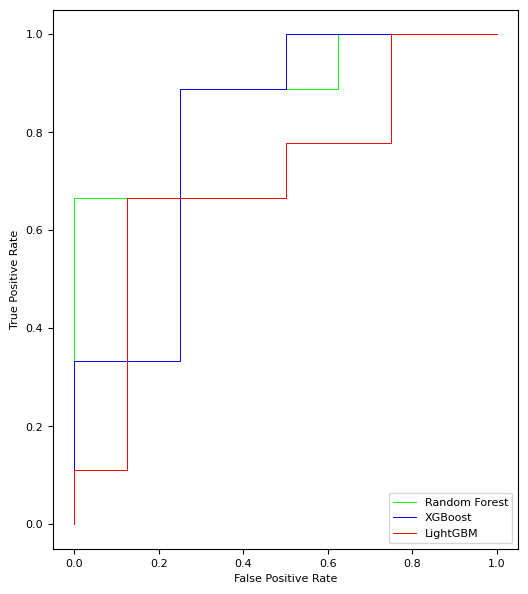

In [17]:
plt.figure(figsize=(6, 7))
colors = {'Random Forest': '#00FF00', 'XGBoost': '#0000FF', 'LightGBM': '#FF0000'}

for name, outputs in model_outputs.items():
    get_roc_curve(y_test, outputs[0], name, colors[name])

plt.show()

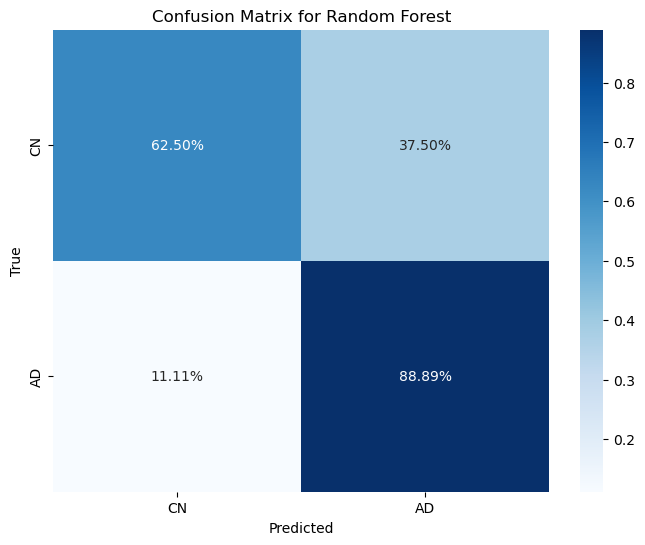

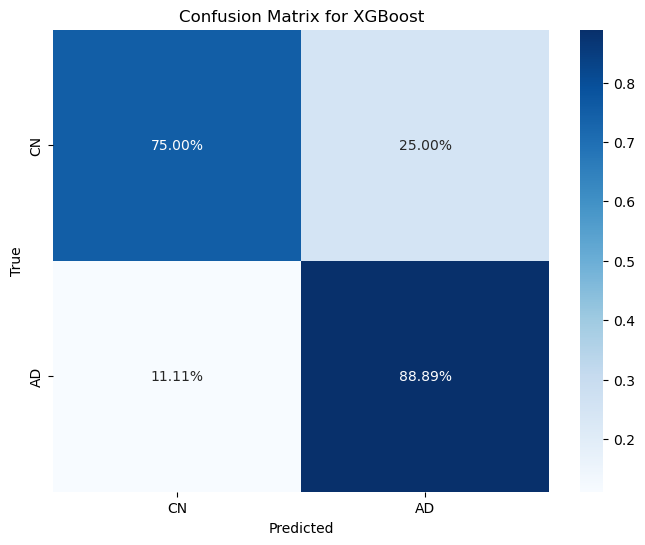

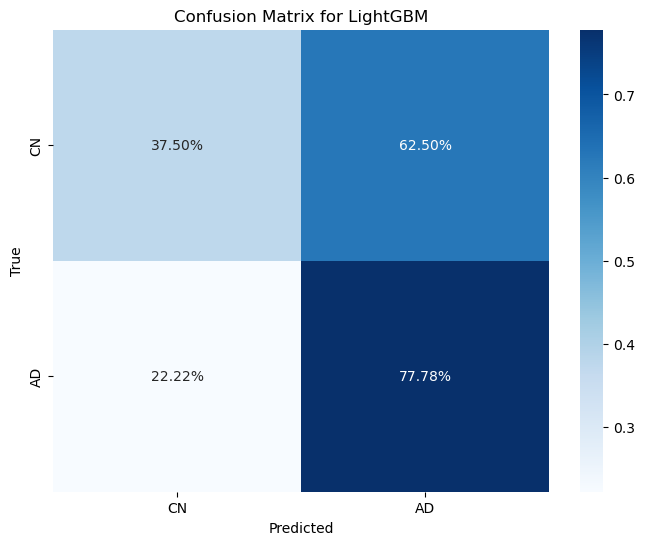

In [18]:
class_names = ['CN', 'AD']

for name, outputs in model_outputs.items():
    get_confusion_matrix(y_test, outputs[1], class_names, name)

In [19]:
results_df = get_performance_metrics(y_test, model_outputs)
print(results_df)

           Model  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)
0  Random Forest     76.470588      78.030303   75.694444     75.714286
1        XGBoost     82.352941      82.857143   81.944444     82.105263
2       LightGBM     58.823529      59.166667   57.638889     56.410256


In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
import lightgbm as lgb # light XGBoost package

classification_models = [
    KNeighborsClassifier(),
    SVC(kernel='linear'),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    xgb.XGBClassifier(),
    lgb.LGBMClassifier(verbosity=-1)
 
]


scores = []
for model in classification_models:
    try:
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        model_name = type(model).__name__
        if isinstance(model, SVC) and model.kernel == 'rbf':
            model_name += ' RBF kernel'
        scores.append((model_name, f'{100*score:.2f}%'))
    except ValueError as e:
        print(f"Error training {type(model).__name__}: {str(e)}")


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [21]:
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
8,XGBClassifier,82.35%
4,RandomForestClassifier,76.47%
6,GaussianNB,70.59%
0,KNeighborsClassifier,64.71%
3,DecisionTreeClassifier,64.71%
5,AdaBoostClassifier,64.71%
1,SVC,58.82%
9,LGBMClassifier,58.82%
2,SVC RBF kernel,52.94%
7,QuadraticDiscriminantAnalysis,52.94%
